# NB08 — ∂Y/∂x_onehot: One-Hot Jacobian

**Motivation**: NB05/06 computed ∂Y/∂pert_repr (gradient w.r.t. the 328-dim embedding). A teammate asked whether running it on the raw one-hot input would be more interpretable — since each dimension of the gradient directly corresponds to a specific perturbation, nudging it = mixing perturbations.

**Key shortcut**: since `pert_encoder` is a single linear layer (W ∈ R^{328×2024}), by the chain rule:

```
∂Y/∂x_onehot = (∂Y/∂pert_repr) @ W
```

No GPU recomputation needed — just matrix-multiply the existing NB05 Jacobians [225, 2000, 328] by W [328, 2024] to get [225, 2000, 2024].

**What changes vs NB05**:
- Each pair's Jacobian similarity now reflects similarity of how their *output gene responses* vary when mixing in other perturbations
- Column j of a KD's Jacobian = how much each output gene changes if you add a small amount of perturbation j

**Analysis**: same Pearson/Spearman + decile plot as NB07, now for the one-hot Jacobian.


In [1]:

nb08_script = """
import numpy as np
import pandas as pd
import pickle
import torch
from scipy.stats import pearsonr, spearmanr, sem
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
MODELS  = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models'

# ── Load fewshot pert_encoder weight matrix ──────────────────────────────────
print("[1] Loading fewshot model pert_encoder weights...")
import sys
sys.path.insert(0, '/mnt/polished-lake/home/mbeheleramass/state/src')
from state.tx.models.state_transition import StateTransitionPerturbationModel
import glob

ckpt_paths = sorted(glob.glob(f'{MODELS}/fewshot/hepg2/**/*.ckpt', recursive=True))
print(f"  Found checkpoints: {ckpt_paths}")
ckpt_path = ckpt_paths[-1]
model = StateTransitionPerturbationModel.load_from_checkpoint(ckpt_path, map_location='cpu')
model.eval()

# pert_encoder is Sequential(Linear(2024->328))
W = model.pert_encoder[0].weight.detach().numpy()  # [328, 2024]
print(f"  W shape: {W.shape}")

# ── Load NB05 Jacobians ∂Y/∂pert_repr ────────────────────────────────────────
print("[2] Loading NB05 Jacobians [225, 2000, 328]...")
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')           # [225, 2000, 328]
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')
print(f"  jac5: {jac5.shape}")

# ── Chain rule: ∂Y/∂x_onehot = (∂Y/∂pert_repr) @ W ─────────────────────────
# jac5:  [225, 2000, 328]
# W^T:   [328, 2024]
# result: [225, 2000, 2024]
print("[3] Computing ∂Y/∂x_onehot via chain rule (no GPU needed)...")
jac_onehot = jac5 @ W          # [225, 2000, 2024]
print(f"  jac_onehot: {jac_onehot.shape}")
print(f"  Memory: {jac_onehot.nbytes / 1e9:.2f} GB")
np.save(f'{OUTDIR}/nb08_jacobians_onehot.npy', jac_onehot)
print(f"  Saved nb08_jacobians_onehot.npy")

# ── Pairwise cosine similarities ─────────────────────────────────────────────
print("[4] Computing pairwise cosine similarities...")
n = len(kd5)
jac_flat = jac_onehot.reshape(n, -1).astype(np.float32)  # [225, 2000*2024]
print(f"  Flattened: {jac_flat.shape}, {jac_flat.nbytes/1e9:.2f} GB")

jac_sim  = cosine_similarity(jac_flat)    # [225, 225]
dy_vals  = dy5.reindex(kd5).values.astype(np.float32)
dy_sim   = cosine_similarity(dy_vals)     # [225, 225]

idx = np.triu_indices(n, k=1)
jac_pairs = jac_sim[idx]
dy_pairs  = dy_sim[idx]
print(f"  Pairs: {len(jac_pairs):,}")

pr, _ = pearsonr(jac_pairs, dy_pairs)
sr, sp = spearmanr(jac_pairs, dy_pairs)
print(f"  One-hot Jacobian: Pearson r={pr:.4f}, Spearman r={sr:.4f} (p={sp:.2e})")

# NB05 reference (pert_repr Jacobian)
pr5_ref = 0.1192
sr5_ref = 0.0936

# ── Decile binning ────────────────────────────────────────────────────────────
print("[5] Decile binning...")
N_BINS = 10

def decile_means(dy_sims, jac_sims, n_bins=N_BINS):
    rank_jac  = np.argsort(np.argsort(jac_sims)) / len(jac_sims)
    bin_edges = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))
    bin_edges[-1] += 1e-9
    labels = np.clip(np.digitize(dy_sims, bin_edges) - 1, 0, n_bins - 1)
    centres, means, errors = [], [], []
    for b in range(n_bins):
        mask = labels == b
        vals = rank_jac[mask]
        centres.append(dy_sims[mask].mean())
        means.append(vals.mean())
        errors.append(sem(vals))
    return np.array(centres), np.array(means), np.array(errors)

# For the decile plot we also want the NB05 pert_repr result for comparison
jac5_pr = np.load(f'{OUTDIR}/nb05_jacobians.npy')
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5_pr = pickle.load(f)
jac5_pr_flat = jac5_pr.reshape(len(kd5_pr), -1).astype(np.float32)
jac5_pr_sim  = cosine_similarity(jac5_pr_flat)
jac5_pr_pairs = jac5_pr_sim[idx]

c_oh, m_oh, e_oh = decile_means(dy_pairs, jac_pairs)
c_pr, m_pr, e_pr = decile_means(dy_pairs, jac5_pr_pairs)

# ── Figure ────────────────────────────────────────────────────────────────────
print("[6] Plotting...")
COL_OH = '#7C3AED'   # purple for one-hot
COL_PR = '#2563EB'   # blue for pert_repr (same as NB07)

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle('One-hot vs Pert-repr Jacobian — Routing Coherence Comparison',
             fontsize=13, fontweight='bold', y=1.01)

# Panel A: bar chart
ax = axes[0]
labels_bar = ['Pearson r', 'Spearman r']
x = np.array([0, 1])
w = 0.3
b1 = ax.bar(x - w/2, [pr, sr], w, color=COL_OH, alpha=0.85,
            label='One-hot Jacobian (NB08)')
b2 = ax.bar(x + w/2, [pr5_ref, sr5_ref], w, color=COL_PR, alpha=0.85,
            label='Pert-repr Jacobian (NB05)')
for bar, val, col in zip(list(b1)+list(b2),
                         [pr, sr, pr5_ref, sr5_ref],
                         [COL_OH, COL_OH, COL_PR, COL_PR]):
    offset = 0.005 if val >= 0 else -0.007
    va = 'bottom' if val >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, val + offset,
            f'{val:.3f}', ha='center', va=va, fontsize=10,
            fontweight='bold', color=col)
ax.axhline(0, color='black', lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(labels_bar, fontsize=12)
ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)
ax.set_ylim(-0.04, 0.22)
ax.legend(fontsize=9, loc='upper left')
ax.grid(axis='y', alpha=0.3, lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('A   Summary statistics', fontsize=11, loc='left', fontweight='bold')

# Panel B: decile line plot
ax2 = axes[1]
ax2.errorbar(c_oh, m_oh, yerr=e_oh, color=COL_OH, marker='o', ms=6, lw=2,
             capsize=3, label=f'One-hot   Spearman r={sr:.3f} (p={sp:.1e})', zorder=3)
ax2.errorbar(c_pr, m_pr, yerr=e_pr, color=COL_PR, marker='s', ms=6, lw=2,
             capsize=3, label=f'Pert-repr Spearman r={sr5_ref:.3f} (p=4e-50)', zorder=3)
ax2.axhline(0.5, color='gray', lw=1.2, linestyle='--', alpha=0.6, label='Flat (no correlation)')
ax2.set_xlabel('ΔY cosine similarity (binned into deciles)', fontsize=10)
ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1, mean +/- SE)', fontsize=10)
ax2.set_title('B   Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, lw=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
outpath = f'{OUTDIR}/nb08_onehot_jacobian.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run.py', 'w') as fh:
    fh.write(nb08_script)
print("Written.")


Written.


In [2]:

import subprocess

result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run.py'],
    capture_output=True, text=True, timeout=600
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-3000:])
print("Return code:", result.returncode)


[1] Loading fewshot model pert_encoder weights...
  Found checkpoints: []

STDERR: Traceback (most recent call last):
  File "/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run.py", line 24, in <module>
    ckpt_path = ckpt_paths[-1]
IndexError: list index out of range

Return code: 1


In [3]:

nb08_script = """
import numpy as np
import pandas as pd
import pickle
import torch
from scipy.stats import pearsonr, spearmanr, sem
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

OUTDIR = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
CKPT   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'

# ── Extract pert_encoder weight from checkpoint (no model instantiation needed) ──
print("[1] Extracting pert_encoder weight matrix from checkpoint...")
sd = torch.load(CKPT, map_location='cpu', weights_only=False)
state = sd.get('state_dict', sd)
# key is e.g. 'pert_encoder.0.weight'
W = state['pert_encoder.0.weight'].numpy()   # [328, 2024]
print(f"  W shape: {W.shape}")

# ── Load NB05 Jacobians [225, 2000, 328] ─────────────────────────────────────
print("[2] Loading NB05 Jacobians...")
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')           # [225, 2000, 328]
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')
print(f"  jac5: {jac5.shape}")

# ── Chain rule: ∂Y/∂x_onehot = (∂Y/∂pert_repr) @ W ─────────────────────────
print("[3] Chain rule multiply: [225,2000,328] @ [328,2024] -> [225,2000,2024]...")
jac_onehot = jac5 @ W    # [225, 2000, 2024]
print(f"  jac_onehot: {jac_onehot.shape}, {jac_onehot.nbytes/1e9:.2f} GB")
np.save(f'{OUTDIR}/nb08_jacobians_onehot.npy', jac_onehot)
print("  Saved nb08_jacobians_onehot.npy")

# ── Pairwise cosine similarities ─────────────────────────────────────────────
print("[4] Pairwise cosine similarities...")
n = len(kd5)
idx = np.triu_indices(n, k=1)

jac_flat    = jac_onehot.reshape(n, -1).astype(np.float32)
jac_sim_oh  = cosine_similarity(jac_flat)[idx]

dy_vals     = dy5.reindex(kd5).values.astype(np.float32)
dy_sim      = cosine_similarity(dy_vals)[idx]

# also pert_repr pairs for comparison
jac_flat_pr = jac5.reshape(n, -1).astype(np.float32)
jac_sim_pr  = cosine_similarity(jac_flat_pr)[idx]

pr_oh, _ = pearsonr(jac_sim_oh, dy_sim)
sr_oh, sp_oh = spearmanr(jac_sim_oh, dy_sim)
pr_pr, _ = pearsonr(jac_sim_pr, dy_sim)
sr_pr, sp_pr = spearmanr(jac_sim_pr, dy_sim)
print(f"  One-hot:   Pearson={pr_oh:.4f}, Spearman={sr_oh:.4f} (p={sp_oh:.2e})")
print(f"  Pert-repr: Pearson={pr_pr:.4f}, Spearman={sr_pr:.4f} (p={sp_pr:.2e})")

# ── Decile binning ────────────────────────────────────────────────────────────
N_BINS = 10

def decile_means(dy_sims, jac_sims, n_bins=N_BINS):
    rank_jac  = np.argsort(np.argsort(jac_sims)) / len(jac_sims)
    bin_edges = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))
    bin_edges[-1] += 1e-9
    labels = np.clip(np.digitize(dy_sims, bin_edges) - 1, 0, n_bins - 1)
    centres, means, errors = [], [], []
    for b in range(n_bins):
        mask = labels == b
        vals = rank_jac[mask]
        centres.append(dy_sims[mask].mean())
        means.append(vals.mean())
        errors.append(sem(vals))
    return np.array(centres), np.array(means), np.array(errors)

c_oh, m_oh, e_oh = decile_means(dy_sim, jac_sim_oh)
c_pr, m_pr, e_pr = decile_means(dy_sim, jac_sim_pr)

# ── Figure ────────────────────────────────────────────────────────────────────
COL_OH = '#7C3AED'
COL_PR = '#2563EB'

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle('One-hot vs Pert-repr Jacobian  —  Routing Coherence',
             fontsize=13, fontweight='bold', y=1.01)

# Panel A: bar chart
ax = axes[0]
x = np.array([0, 1])
w = 0.3
b1 = ax.bar(x - w/2, [pr_oh, sr_oh], w, color=COL_OH, alpha=0.85, label='One-hot (NB08)')
b2 = ax.bar(x + w/2, [pr_pr, sr_pr], w, color=COL_PR, alpha=0.85, label='Pert-repr (NB05)')
for bar, val, col in zip(list(b1)+list(b2),
                         [pr_oh, sr_oh, pr_pr, sr_pr],
                         [COL_OH, COL_OH, COL_PR, COL_PR]):
    offset = 0.005 if val >= 0 else -0.007
    va = 'bottom' if val >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, val + offset,
            f'{val:.3f}', ha='center', va=va, fontsize=10, fontweight='bold', color=col)
ax.axhline(0, color='black', lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Pearson r', 'Spearman r'], fontsize=12)
ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)
ax.set_ylim(-0.05, 0.22)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3, lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('A   Summary statistics', fontsize=11, loc='left', fontweight='bold')

# Panel B: decile line plot
ax2 = axes[1]
ax2.errorbar(c_oh, m_oh, yerr=e_oh, color=COL_OH, marker='o', ms=6, lw=2,
             capsize=3, label=f'One-hot   Spearman r={sr_oh:.3f} (p={sp_oh:.1e})', zorder=3)
ax2.errorbar(c_pr, m_pr, yerr=e_pr, color=COL_PR, marker='s', ms=6, lw=2,
             capsize=3, label=f'Pert-repr Spearman r={sr_pr:.3f} (p={sp_pr:.1e})', zorder=3)
ax2.axhline(0.5, color='gray', lw=1.2, linestyle='--', alpha=0.6, label='Flat (no correlation)')
ax2.set_xlabel('ΔY cosine similarity (binned into deciles)', fontsize=10)
ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1, mean +/- SE)', fontsize=10)
ax2.set_title('B   Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, lw=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
outpath = f'{OUTDIR}/nb08_onehot_jacobian.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run.py', 'w') as fh:
    fh.write(nb08_script)

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run.py'],
    capture_output=True, text=True, timeout=600
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


[1] Extracting pert_encoder weight matrix from checkpoint...
  W shape: (328, 2024)
[2] Loading NB05 Jacobians...
  jac5: (225, 2000, 328)
[3] Chain rule multiply: [225,2000,328] @ [328,2024] -> [225,2000,2024]...
  jac_onehot: (225, 2000, 2024), 3.64 GB
  Saved nb08_jacobians_onehot.npy
[4] Pairwise cosine similarities...
  One-hot:   Pearson=0.1953, Spearman=0.1509 (p=3.38e-128)
  Pert-repr: Pearson=0.1192, Spearman=0.0936 (p=3.83e-50)
Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.png

Return code: 0


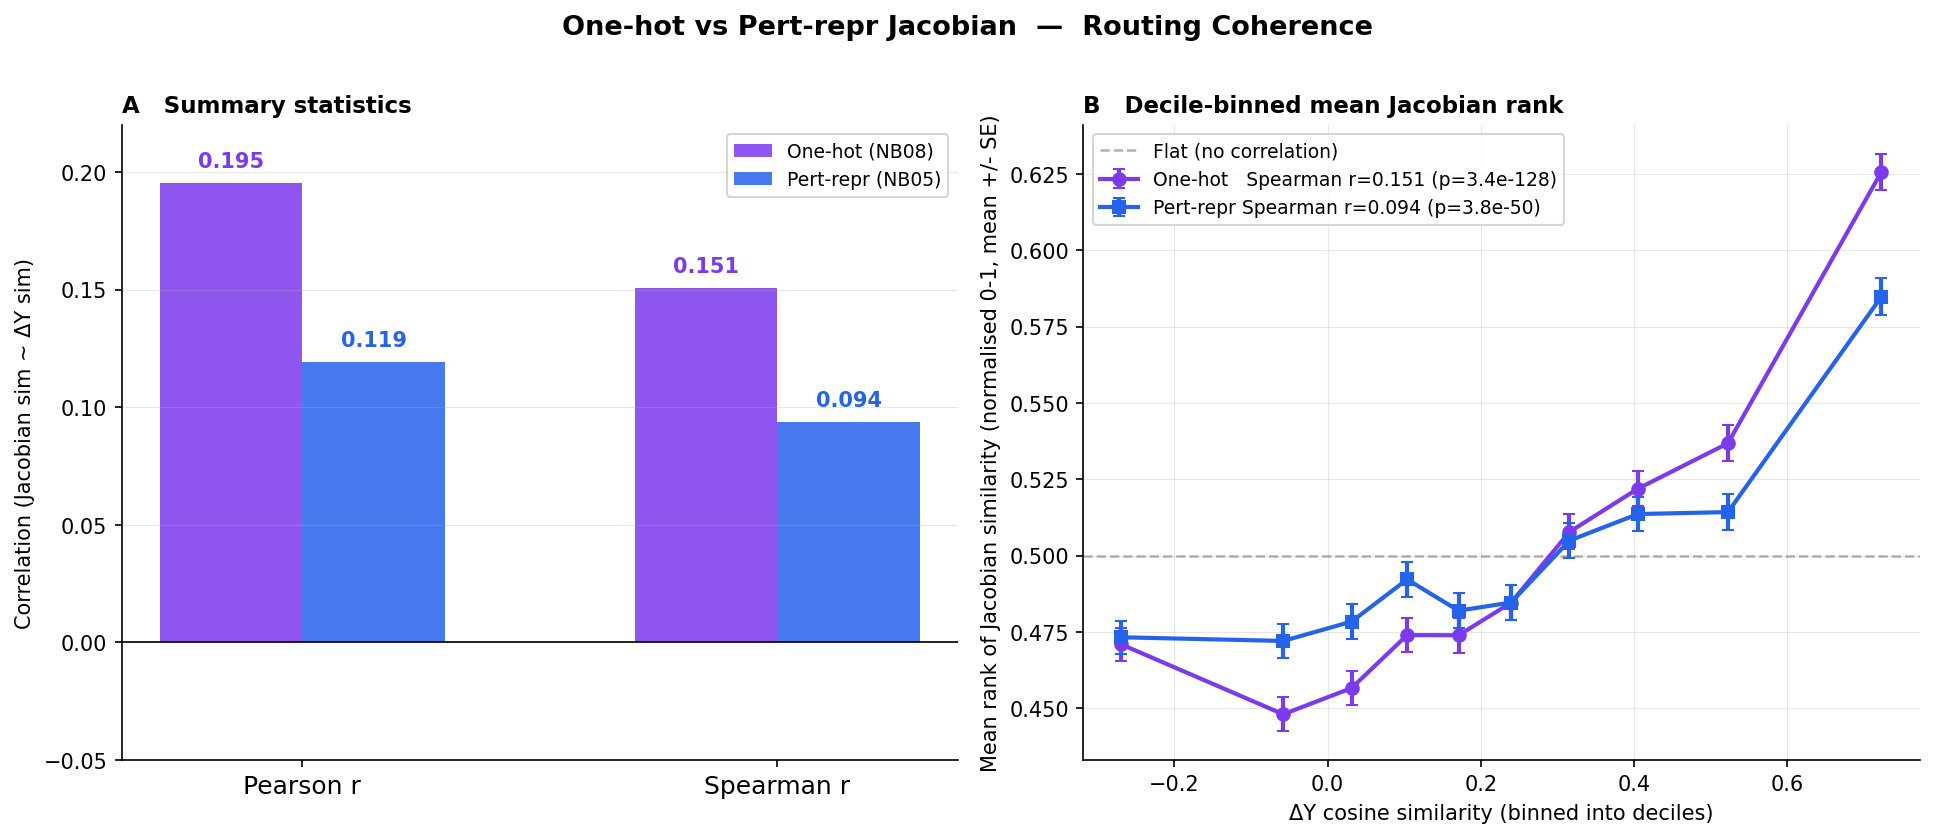

In [4]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.png', width=1100))


In [5]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-17-16_nb08_onehot_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")


Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb


In [6]:

nb08_ext_script = """
import numpy as np
import pandas as pd
import pickle
import torch
from scipy.stats import pearsonr, spearmanr, sem
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

OUTDIR    = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
CKPT_FS   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'
CKPT_ZS   = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/zeroshot/hepg2/checkpoints/best.ckpt'

# ── Extract pert_encoder W from both checkpoints ──────────────────────────────
print("[1] Extracting pert_encoder weights...")
def get_W(ckpt_path):
    sd = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    state = sd.get('state_dict', sd)
    return state['pert_encoder.0.weight'].numpy()   # [328, 2024]

W_fs = get_W(CKPT_FS)
W_zs = get_W(CKPT_ZS)
print(f"  W_fewshot:  {W_fs.shape}")
print(f"  W_zeroshot: {W_zs.shape}")

# ── Load pert_repr Jacobians ──────────────────────────────────────────────────
print("[2] Loading NB05/NB06 pert_repr Jacobians...")
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')   # [225, 2000, 328]
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')

jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')   # [225, 2000, 328]
with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f:
    kd6 = pickle.load(f)
dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')

# ── Chain rule → one-hot Jacobians ───────────────────────────────────────────
print("[3] Chain rule: pert_repr Jacobian @ W -> one-hot Jacobian...")
jac_oh_fs = jac5 @ W_fs   # [225, 2000, 2024]
jac_oh_zs = jac6 @ W_zs   # [225, 2000, 2024]
print(f"  fewshot  one-hot Jacobian: {jac_oh_fs.shape}")
print(f"  zeroshot one-hot Jacobian: {jac_oh_zs.shape}")

# ── Pairwise cosine similarities ─────────────────────────────────────────────
print("[4] Pairwise cosine similarities...")
n = 225
idx = np.triu_indices(n, k=1)

def get_pairs(jac, kd_names, dy_df):
    jac_sim = cosine_similarity(jac.reshape(n, -1).astype(np.float32))[idx]
    dy_sim  = cosine_similarity(dy_df.reindex(kd_names).values.astype(np.float32))[idx]
    return jac_sim, dy_sim

jac_pairs_fs, dy_pairs_fs = get_pairs(jac_oh_fs, kd5, dy5)
jac_pairs_zs, dy_pairs_zs = get_pairs(jac_oh_zs, kd6, dy6)

pr_fs, _     = pearsonr(jac_pairs_fs, dy_pairs_fs)
sr_fs, sp_fs = spearmanr(jac_pairs_fs, dy_pairs_fs)
pr_zs, _     = pearsonr(jac_pairs_zs, dy_pairs_zs)
sr_zs, sp_zs = spearmanr(jac_pairs_zs, dy_pairs_zs)
print(f"  Fewshot  one-hot: Pearson={pr_fs:.4f}, Spearman={sr_fs:.4f} (p={sp_fs:.2e})")
print(f"  Zeroshot one-hot: Pearson={pr_zs:.4f}, Spearman={sr_zs:.4f} (p={sp_zs:.2e})")

# ── Decile binning ────────────────────────────────────────────────────────────
N_BINS = 10

def decile_means(dy_sims, jac_sims, n_bins=N_BINS):
    rank_jac  = np.argsort(np.argsort(jac_sims)) / len(jac_sims)
    bin_edges = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))
    bin_edges[-1] += 1e-9
    labels = np.clip(np.digitize(dy_sims, bin_edges) - 1, 0, n_bins - 1)
    centres, means, errors = [], [], []
    for b in range(n_bins):
        mask = labels == b
        vals = rank_jac[mask]
        centres.append(dy_sims[mask].mean())
        means.append(vals.mean())
        errors.append(sem(vals))
    return np.array(centres), np.array(means), np.array(errors)

c_fs, m_fs, e_fs = decile_means(dy_pairs_fs, jac_pairs_fs)
c_zs, m_zs, e_zs = decile_means(dy_pairs_zs, jac_pairs_zs)

# ── Figure ────────────────────────────────────────────────────────────────────
COL_FS = '#2563EB'
COL_ZS = '#DC2626'

fig, axes = plt.subplots(1, 2, figsize=(13, 5.5))
fig.suptitle('One-hot Jacobian: Fewshot vs Zeroshot  —  Routing Coherence',
             fontsize=13, fontweight='bold', y=1.01)

# Panel A: bar chart
ax = axes[0]
x = np.array([0, 1])
w = 0.3
b1 = ax.bar(x - w/2, [pr_fs, sr_fs], w, color=COL_FS, alpha=0.85, label='Fewshot/HepG2')
b2 = ax.bar(x + w/2, [pr_zs, sr_zs], w, color=COL_ZS, alpha=0.85, label='Zeroshot/HepG2')
for bar, val, col in zip(list(b1)+list(b2),
                         [pr_fs, sr_fs, pr_zs, sr_zs],
                         [COL_FS, COL_FS, COL_ZS, COL_ZS]):
    offset = 0.005 if val >= 0 else -0.007
    va = 'bottom' if val >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, val + offset,
            f'{val:.3f}', ha='center', va=va, fontsize=10, fontweight='bold', color=col)

# p-value callouts on Spearman bars
ax.annotate(f'p={sp_fs:.1e}', xy=(x[1] - w/2, sr_fs), xytext=(x[1] + 0.05, sr_fs + 0.03),
            fontsize=8.5, color=COL_FS, arrowprops=dict(arrowstyle='->', color=COL_FS, lw=0.8))
p_label = f'p={sp_zs:.2f} (NS)' if sp_zs > 0.05 else f'p={sp_zs:.1e}'
ax.annotate(p_label, xy=(x[1] + w/2, sr_zs), xytext=(x[1] + 0.3, sr_zs - 0.03),
            fontsize=8.5, color=COL_ZS, arrowprops=dict(arrowstyle='->', color=COL_ZS, lw=0.8))

ax.axhline(0, color='black', lw=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['Pearson r', 'Spearman r'], fontsize=12)
ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)
ax.set_ylim(-0.05, 0.28)
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3, lw=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('A   Summary statistics', fontsize=11, loc='left', fontweight='bold')

# Panel B: decile line plot
ax2 = axes[1]
ax2.errorbar(c_fs, m_fs, yerr=e_fs, color=COL_FS, marker='o', ms=6, lw=2, capsize=3,
             label=f'Fewshot   Spearman r={sr_fs:.3f} (p={sp_fs:.1e})', zorder=3)
ax2.errorbar(c_zs, m_zs, yerr=e_zs, color=COL_ZS, marker='s', ms=6, lw=2, capsize=3,
             label=f'Zeroshot  Spearman r={sr_zs:.3f} (p={sp_zs:.2f})', zorder=3)
ax2.axhline(0.5, color='gray', lw=1.2, linestyle='--', alpha=0.6, label='Flat (no correlation)')
ax2.set_xlabel('ΔY cosine similarity (binned into deciles)', fontsize=10)
ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1, mean +/- SE)', fontsize=10)
ax2.set_title('B   Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3, lw=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
outpath = f'{OUTDIR}/nb08_onehot_fewshot_vs_zeroshot.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_ext_run.py', 'w') as fh:
    fh.write(nb08_ext_script)

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_ext_run.py'],
    capture_output=True, text=True, timeout=600
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


[1] Extracting pert_encoder weights...
  W_fewshot:  (328, 2024)
  W_zeroshot: (328, 2024)
[2] Loading NB05/NB06 pert_repr Jacobians...
[3] Chain rule: pert_repr Jacobian @ W -> one-hot Jacobian...
  fewshot  one-hot Jacobian: (225, 2000, 2024)
  zeroshot one-hot Jacobian: (225, 2000, 2024)
[4] Pairwise cosine similarities...
  Fewshot  one-hot: Pearson=0.1953, Spearman=0.1509 (p=3.38e-128)
  Zeroshot one-hot: Pearson=0.1754, Spearman=0.0583 (p=2.06e-20)
Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_fewshot_vs_zeroshot.png

Return code: 0


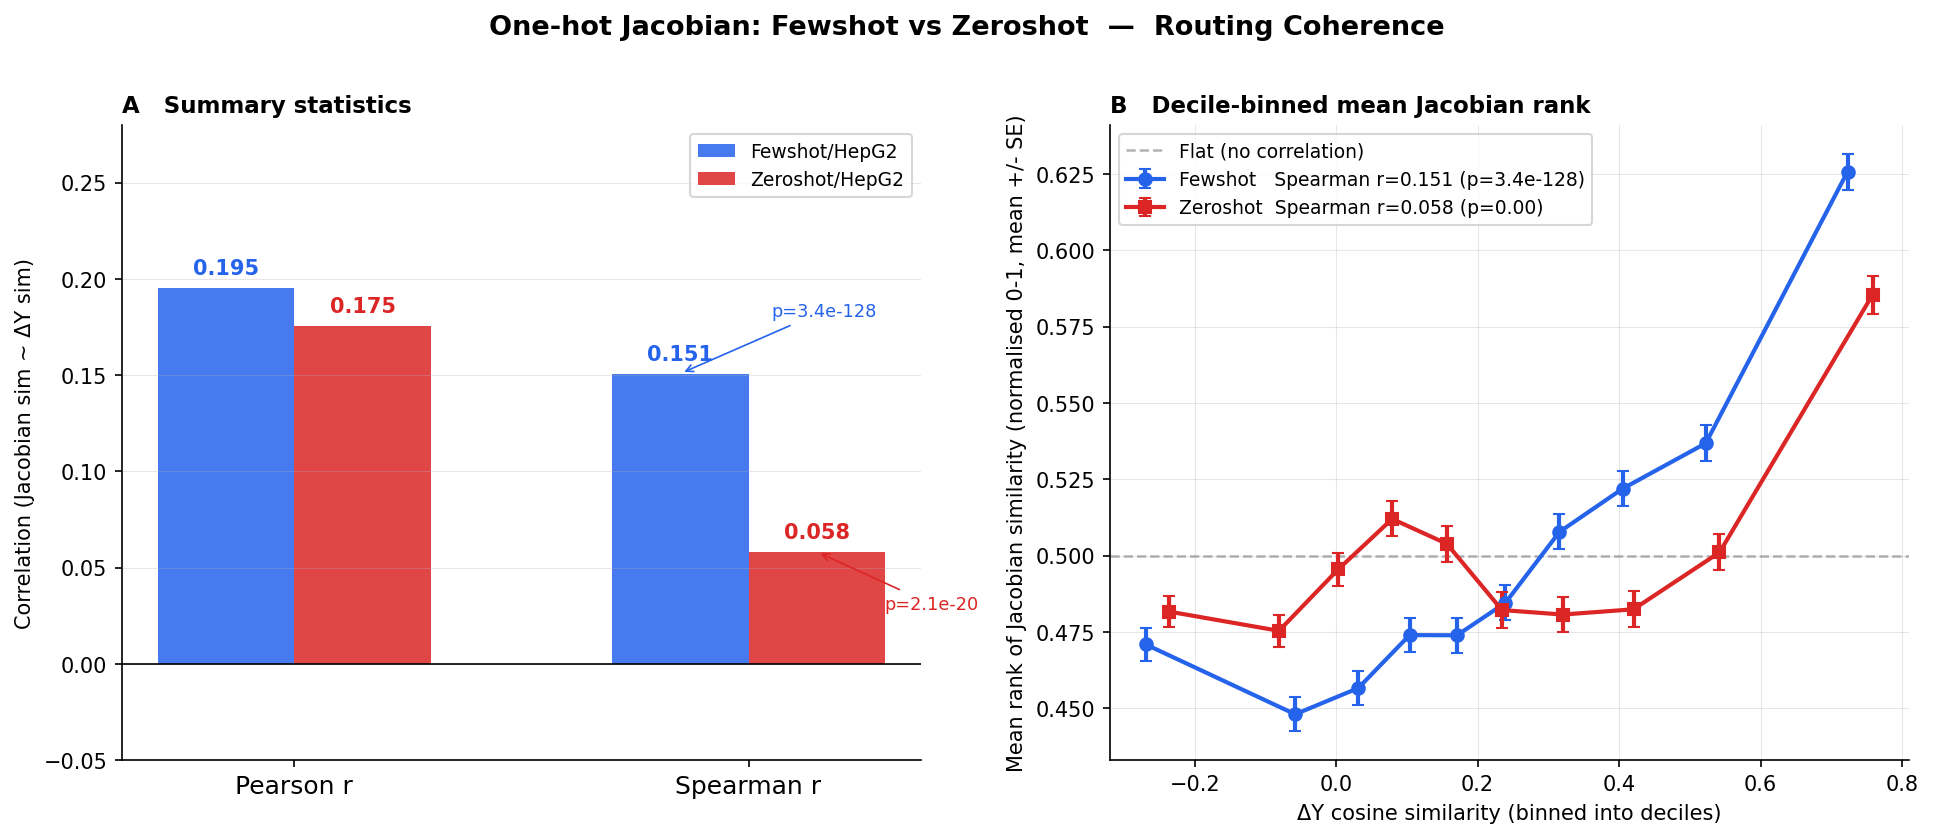

In [7]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_fewshot_vs_zeroshot.png', width=1100))


In [8]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-17-16_nb08_onehot_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")


Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb


In [9]:

nb08_scatter_script = """
import numpy as np
import pandas as pd
import pickle
import torch
from scipy.stats import pearsonr, spearmanr, wilcoxon
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'
CKPT_FS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'
CKPT_ZS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/zeroshot/hepg2/checkpoints/best.ckpt'

# ── Weights ───────────────────────────────────────────────────────────────────
def get_W(path):
    sd = torch.load(path, map_location='cpu', weights_only=False)
    return sd.get('state_dict', sd)['pert_encoder.0.weight'].numpy()

W_fs = get_W(CKPT_FS)
W_zs = get_W(CKPT_ZS)

# ── Jacobians + ΔY + clusters ─────────────────────────────────────────────────
jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')
with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f:
    kd5 = pickle.load(f)
dy5       = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')
clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)

jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')
with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f:
    kd6 = pickle.load(f)
dy6       = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')
clusters6 = pd.read_csv(f'{OUTDIR}/nb06_clusters.csv', index_col=0)

# ── One-hot Jacobians via chain rule ─────────────────────────────────────────
jac_oh_fs = jac5 @ W_fs   # [225, 2000, 2024]
jac_oh_zs = jac6 @ W_zs

# ── Build pairwise arrays with same/diff cluster label ───────────────────────
def build_pairs(jac_oh, kd_names, dy_df, clusters_df):
    n   = len(kd_names)
    idx = np.triu_indices(n, k=1)
    ii, jj = idx

    jac_sim = cosine_similarity(jac_oh.reshape(n, -1).astype(np.float32))[idx]
    dy_sim  = cosine_similarity(dy_df.reindex(kd_names).values.astype(np.float32))[idx]

    # cluster label per rep KD (use clusters_df which covers all 2023 KDs)
    clust = clusters_df['cluster'].reindex(kd_names)
    same  = (clust.values[ii] == clust.values[jj]).astype(bool)
    return jac_sim, dy_sim, same

js_fs, dy_fs, same_fs = build_pairs(jac_oh_fs, kd5, dy5, clusters5)
js_zs, dy_zs, same_zs = build_pairs(jac_oh_zs, kd6, dy6, clusters6)

# ── Stats ─────────────────────────────────────────────────────────────────────
def stats(jac_sim, dy_sim, same):
    pr, _ = pearsonr(jac_sim, dy_sim)
    sr, _ = spearmanr(jac_sim, dy_sim)
    s_vals = jac_sim[same];  d_vals = jac_sim[~same]
    _, wp  = wilcoxon(s_vals[:len(d_vals)] - d_vals[:len(s_vals)])   # matched-size approx
    _, wp  = wilcoxon(s_vals, d_vals[:len(s_vals)])
    # use mannwhitneyu instead for unequal sizes
    from scipy.stats import mannwhitneyu
    _, wp = mannwhitneyu(s_vals, d_vals, alternative='greater')
    ratio = s_vals.mean() / d_vals.mean()
    return pr, sr, s_vals, d_vals, wp, ratio

pr_fs, sr_fs, s_fs, d_fs, wp_fs, rat_fs = stats(js_fs, dy_fs, same_fs)
pr_zs, sr_zs, s_zs, d_zs, wp_zs, rat_zs = stats(js_zs, dy_zs, same_zs)

print(f"Fewshot:  Pearson={pr_fs:.3f}, Spearman={sr_fs:.3f}, same/diff={rat_fs:.2f}x (p={wp_fs:.2e})")
print(f"Zeroshot: Pearson={pr_zs:.3f}, Spearman={sr_zs:.3f}, same/diff={rat_zs:.2f}x (p={wp_zs:.2e})")

# ── Figure 2x2 ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
fig.suptitle('One-hot Jacobian: Routing vs Output Similarity',
             fontsize=14, fontweight='bold')

COL_SAME = '#DC2626'
COL_DIFF = '#94A3B8'

def scatter_panel(ax, dy_sim, jac_sim, same, pr, sr, title, fs_ref_r=None):
    # subsample diff-cluster pairs for speed (keep all same-cluster)
    rng  = np.random.default_rng(42)
    d_idx = np.where(~same)[0]
    s_idx = np.where(same)[0]
    d_sub = rng.choice(d_idx, size=min(5000, len(d_idx)), replace=False)

    ax.scatter(dy_sim[d_sub], jac_sim[d_sub],
               c=COL_DIFF, alpha=0.15, s=4, rasterized=True,
               label=f'Diff cluster (n={len(d_idx):,})')
    ax.scatter(dy_sim[s_idx], jac_sim[s_idx],
               c=COL_SAME, alpha=0.4, s=6, rasterized=True,
               label=f'Same cluster (n={len(s_idx):,})')

    # regression line
    m, b = np.polyfit(dy_sim, jac_sim, 1)
    xs = np.linspace(dy_sim.min(), dy_sim.max(), 200)
    ax.plot(xs, m*xs + b, color='#1D4ED8', lw=2)

    txt = f'Pearson r={pr:.3f}\nSpearman r={sr:.3f}'
    if fs_ref_r is not None:
        txt += f'\nFewshot ref r={fs_ref_r:.3f}'
    ax.text(0.04, 0.96, txt, transform=ax.transAxes, fontsize=9,
            va='top', color='#1D4ED8',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85,
                      edgecolor='#1D4ED8'))
    ax.set_xlabel('ΔY cosine similarity', fontsize=10)
    ax.set_ylabel('∂Y/∂x_onehot cosine similarity', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right', markerscale=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def violin_panel(ax, s_vals, d_vals, wp, ratio, fs_ratio, title):
    parts = ax.violinplot([s_vals, d_vals], positions=[0, 1],
                          showmedians=True, showextrema=False)
    for i, (pc, col) in enumerate(zip(parts['bodies'], [COL_SAME, COL_DIFF])):
        pc.set_facecolor(col)
        pc.set_alpha(0.6)
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linewidth(2)

    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'Same cluster\\n(n={len(s_vals):,})',
                        f'Diff cluster\\n(n={len(d_vals):,})'], fontsize=10)
    ax.set_ylabel('∂Y/∂x_onehot cosine similarity', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.text(0.5, 0.97,
            f'MWU p={wp:.2e}  |  ratio={ratio:.2f}x  (fewshot: {fs_ratio:.2f}x)',
            transform=ax.transAxes, ha='center', va='top', fontsize=9,
            color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow',
                      alpha=0.9, edgecolor='gray'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

scatter_panel(axes[0,0], dy_fs, js_fs, same_fs, pr_fs, sr_fs,
              'Fewshot — Routing vs Output similarity')
violin_panel(axes[0,1], s_fs, d_fs, wp_fs, rat_fs, rat_fs,
             'Fewshot — Same vs Diff cluster routing')

scatter_panel(axes[1,0], dy_zs, js_zs, same_zs, pr_zs, sr_zs,
              'Zeroshot — Routing vs Output similarity',
              fs_ref_r=pr_fs)
violin_panel(axes[1,1], s_zs, d_zs, wp_zs, rat_zs, rat_fs,
             'Zeroshot — Same vs Diff cluster routing')

plt.tight_layout()
outpath = f'{OUTDIR}/nb08_onehot_routing_vs_output.png'
fig.savefig(outpath, dpi=150, bbox_inches='tight')
print(f"Saved: {outpath}")
"""

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_scatter_run.py', 'w') as fh:
    fh.write(nb08_scatter_script)

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_scatter_run.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)



STDERR:   File "/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_scatter_run.py", line 104
    txt = f'Pearson r={pr:.3f}
          ^
SyntaxError: unterminated string literal (detected at line 104)

Return code: 1


In [10]:

lines = [
"import numpy as np",
"import pandas as pd",
"import pickle",
"import torch",
"from scipy.stats import pearsonr, spearmanr, mannwhitneyu",
"from sklearn.metrics.pairwise import cosine_similarity",
"import matplotlib",
"matplotlib.use('Agg')",
"import matplotlib.pyplot as plt",
"",
"OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'",
"CKPT_FS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'",
"CKPT_ZS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/zeroshot/hepg2/checkpoints/best.ckpt'",
"",
"def get_W(path):",
"    sd = torch.load(path, map_location='cpu', weights_only=False)",
"    return sd.get('state_dict', sd)['pert_encoder.0.weight'].numpy()",
"",
"W_fs = get_W(CKPT_FS)",
"W_zs = get_W(CKPT_ZS)",
"",
"jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')",
"with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f: kd5 = pickle.load(f)",
"dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')",
"clusters5 = pd.read_csv(f'{OUTDIR}/nb05_clusters.csv', index_col=0)",
"",
"jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')",
"with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f: kd6 = pickle.load(f)",
"dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')",
"clusters6 = pd.read_csv(f'{OUTDIR}/nb06_clusters.csv', index_col=0)",
"",
"jac_oh_fs = jac5 @ W_fs",
"jac_oh_zs = jac6 @ W_zs",
"",
"def build_pairs(jac_oh, kd_names, dy_df, clusters_df):",
"    n = len(kd_names)",
"    idx = np.triu_indices(n, k=1)",
"    ii, jj = idx",
"    jac_sim = cosine_similarity(jac_oh.reshape(n, -1).astype(np.float32))[idx]",
"    dy_sim  = cosine_similarity(dy_df.reindex(kd_names).values.astype(np.float32))[idx]",
"    clust = clusters_df['cluster'].reindex(kd_names)",
"    same  = (clust.values[ii] == clust.values[jj]).astype(bool)",
"    return jac_sim, dy_sim, same",
"",
"js_fs, dy_fs, same_fs = build_pairs(jac_oh_fs, kd5, dy5, clusters5)",
"js_zs, dy_zs, same_zs = build_pairs(jac_oh_zs, kd6, dy6, clusters6)",
"",
"def get_stats(jac_sim, dy_sim, same):",
"    pr, _ = pearsonr(jac_sim, dy_sim)",
"    sr, _ = spearmanr(jac_sim, dy_sim)",
"    s_vals = jac_sim[same]; d_vals = jac_sim[~same]",
"    _, wp = mannwhitneyu(s_vals, d_vals, alternative='greater')",
"    ratio = s_vals.mean() / d_vals.mean()",
"    return pr, sr, s_vals, d_vals, wp, ratio",
"",
"pr_fs, sr_fs, s_fs, d_fs, wp_fs, rat_fs = get_stats(js_fs, dy_fs, same_fs)",
"pr_zs, sr_zs, s_zs, d_zs, wp_zs, rat_zs = get_stats(js_zs, dy_zs, same_zs)",
"print(f'Fewshot:  Pearson={pr_fs:.3f}, Spearman={sr_fs:.3f}, ratio={rat_fs:.2f}x (p={wp_fs:.2e})')",
"print(f'Zeroshot: Pearson={pr_zs:.3f}, Spearman={sr_zs:.3f}, ratio={rat_zs:.2f}x (p={wp_zs:.2e})')",
"",
"COL_SAME = '#DC2626'",
"COL_DIFF = '#94A3B8'",
"fig, axes = plt.subplots(2, 2, figsize=(13, 10))",
"fig.suptitle('One-hot Jacobian: Routing vs Output Similarity', fontsize=14, fontweight='bold')",
"",
"def scatter_panel(ax, dy_sim, jac_sim, same, pr, sr, title, fs_ref_r=None):",
"    rng = np.random.default_rng(42)",
"    d_idx = np.where(~same)[0]",
"    s_idx = np.where(same)[0]",
"    d_sub = rng.choice(d_idx, size=min(5000, len(d_idx)), replace=False)",
"    ax.scatter(dy_sim[d_sub], jac_sim[d_sub], c=COL_DIFF, alpha=0.15, s=4,",
"               rasterized=True, label=f'Diff cluster (n={len(d_idx):,})')",
"    ax.scatter(dy_sim[s_idx], jac_sim[s_idx], c=COL_SAME, alpha=0.4, s=6,",
"               rasterized=True, label=f'Same cluster (n={len(s_idx):,})')",
"    m, b = np.polyfit(dy_sim, jac_sim, 1)",
"    xs = np.linspace(dy_sim.min(), dy_sim.max(), 200)",
"    ax.plot(xs, m*xs + b, color='#1D4ED8', lw=2)",
"    lines_txt = [f'Pearson r={pr:.3f}', f'Spearman r={sr:.3f}']",
"    if fs_ref_r is not None: lines_txt.append(f'Fewshot ref r={fs_ref_r:.3f}')",
"    ax.text(0.04, 0.96, chr(10).join(lines_txt), transform=ax.transAxes, fontsize=9,",
"            va='top', color='#1D4ED8',",
"            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85, edgecolor='#1D4ED8'))",
"    ax.set_xlabel('DeltaY cosine similarity', fontsize=10)",
"    ax.set_ylabel('d(Y)/d(x_onehot) cosine similarity', fontsize=10)",
"    ax.set_title(title, fontsize=11, fontweight='bold')",
"    ax.legend(fontsize=8, loc='upper right', markerscale=2)",
"    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)",
"",
"def violin_panel(ax, s_vals, d_vals, wp, ratio, fs_ratio, title):",
"    parts = ax.violinplot([s_vals, d_vals], positions=[0, 1], showmedians=True, showextrema=False)",
"    for pc, col in zip(parts['bodies'], [COL_SAME, COL_DIFF]):",
"        pc.set_facecolor(col); pc.set_alpha(0.6)",
"    parts['cmedians'].set_color('black'); parts['cmedians'].set_linewidth(2)",
"    ax.set_xticks([0, 1])",
"    ax.set_xticklabels([f'Same cluster (n={len(s_vals):,})', f'Diff cluster (n={len(d_vals):,})'], fontsize=10)",
"    ax.set_ylabel('d(Y)/d(x_onehot) cosine similarity', fontsize=10)",
"    ax.set_title(title, fontsize=11, fontweight='bold')",
"    note = f'MWU p={wp:.2e}  |  ratio={ratio:.2f}x  (fewshot: {fs_ratio:.2f}x)'",
"    ax.text(0.5, 0.97, note, transform=ax.transAxes, ha='center', va='top', fontsize=9,",
"            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.9, edgecolor='gray'))",
"    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)",
"",
"scatter_panel(axes[0,0], dy_fs, js_fs, same_fs, pr_fs, sr_fs, 'Fewshot -- Routing vs Output similarity')",
"violin_panel(axes[0,1], s_fs, d_fs, wp_fs, rat_fs, rat_fs, 'Fewshot -- Same vs Diff cluster routing')",
"scatter_panel(axes[1,0], dy_zs, js_zs, same_zs, pr_zs, sr_zs, 'Zeroshot -- Routing vs Output similarity', fs_ref_r=pr_fs)",
"violin_panel(axes[1,1], s_zs, d_zs, wp_zs, rat_zs, rat_fs, 'Zeroshot -- Same vs Diff cluster routing')",
"",
"plt.tight_layout()",
"outpath = f'{OUTDIR}/nb08_onehot_routing_vs_output.png'",
"fig.savefig(outpath, dpi=150, bbox_inches='tight')",
"print(f'Saved: {outpath}')",
]

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_scatter_run.py', 'w') as fh:
    fh.write('\n'.join(lines))

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_scatter_run.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


Fewshot:  Pearson=0.195, Spearman=0.151, ratio=1.99x (p=4.23e-68)
Zeroshot: Pearson=0.175, Spearman=0.058, ratio=2.59x (p=1.24e-101)
Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_routing_vs_output.png

Return code: 0


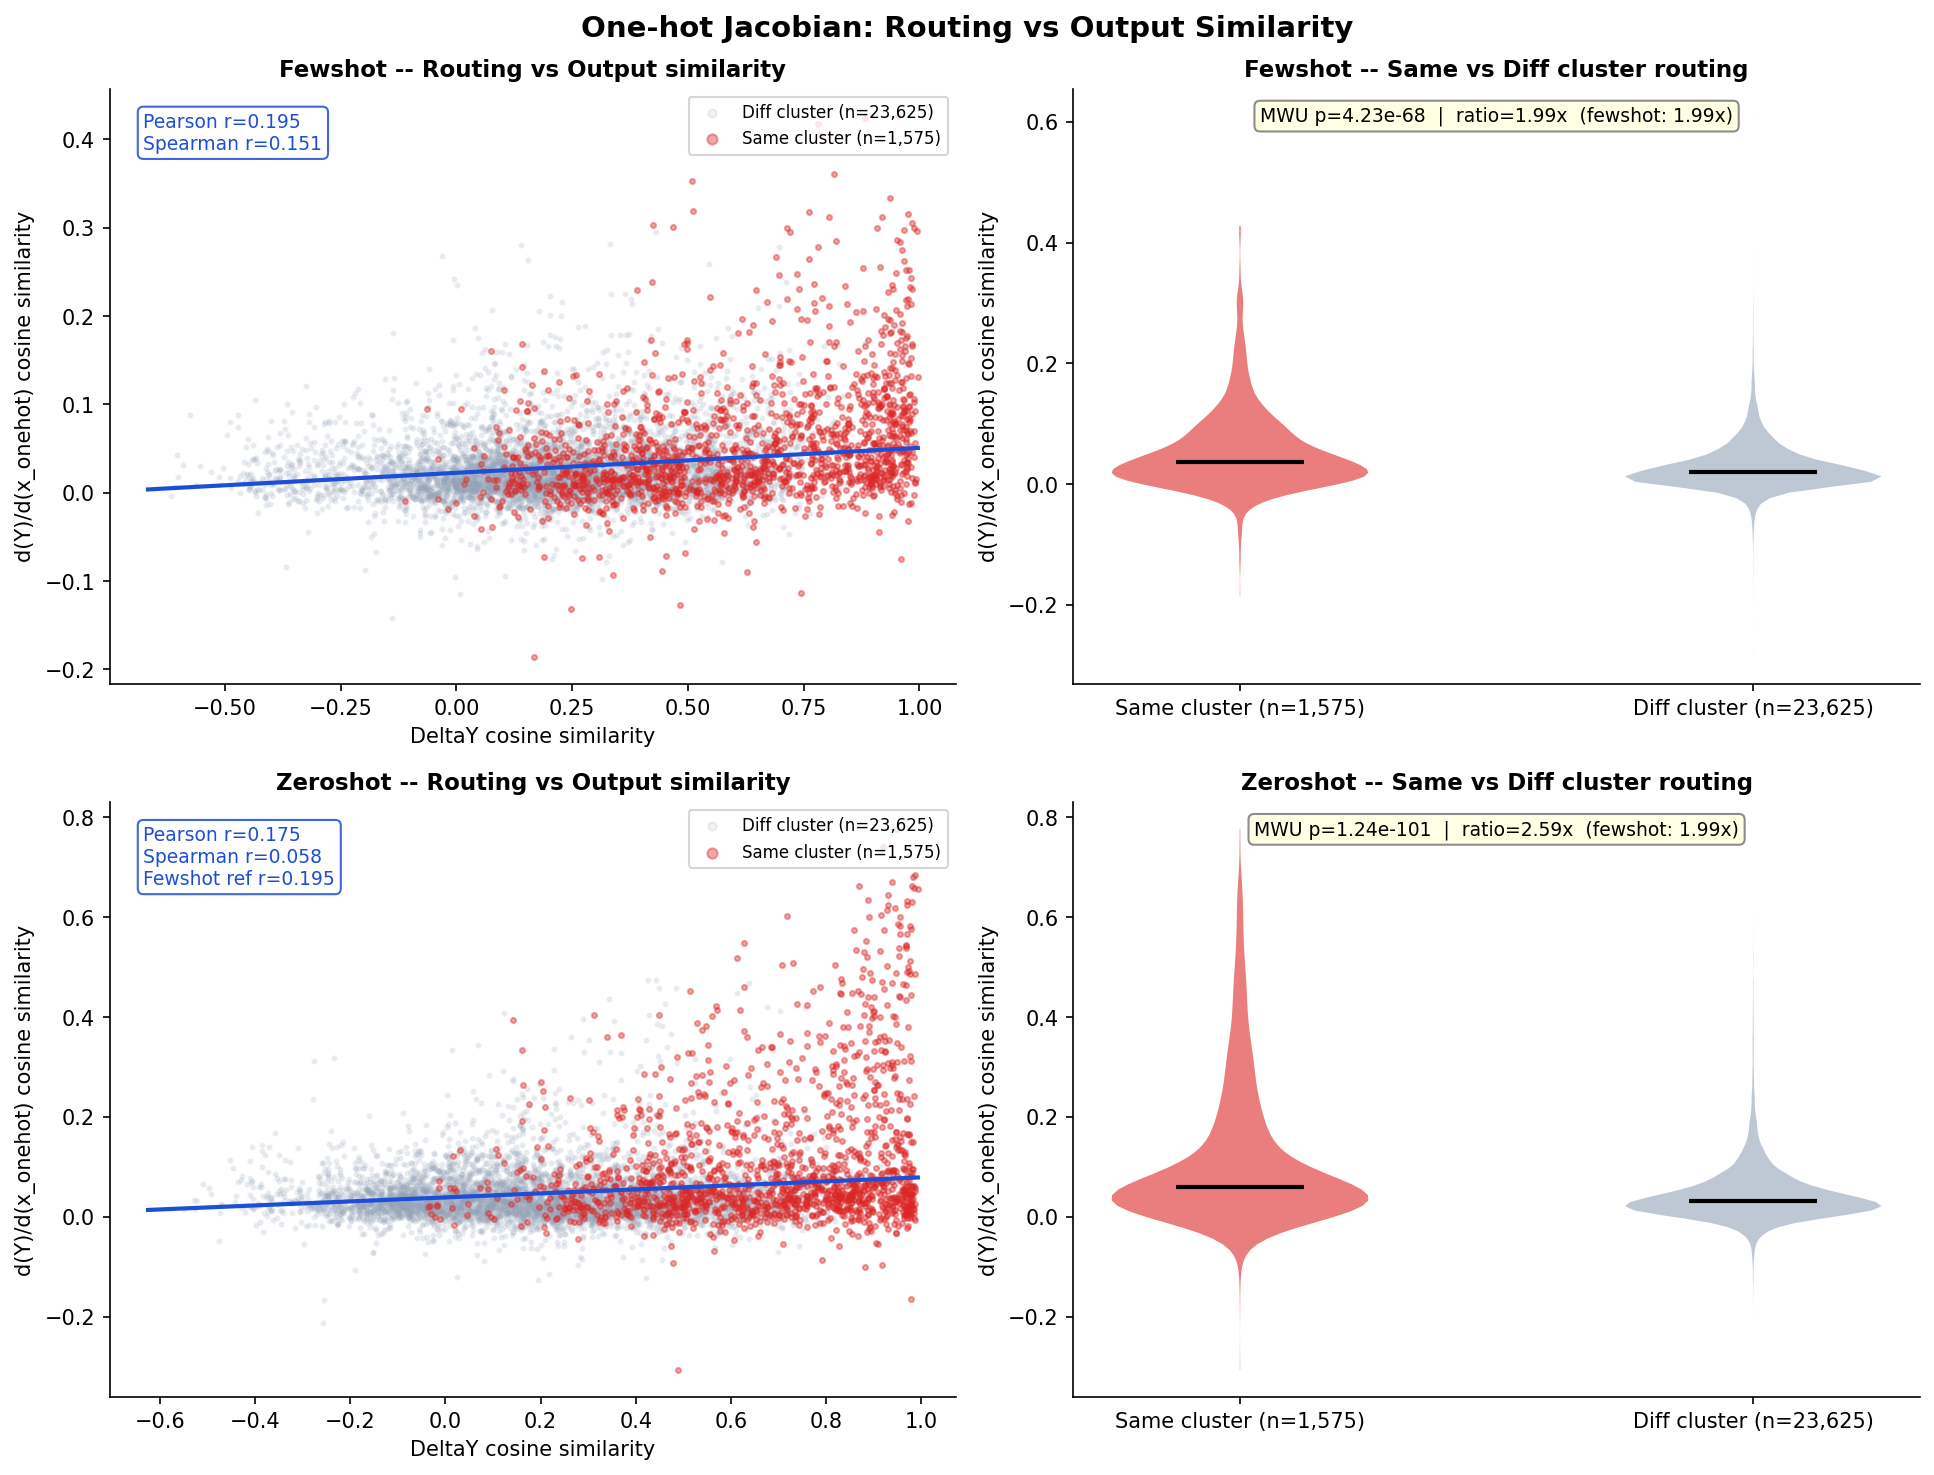

In [11]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_routing_vs_output.png', width=1100))


In [12]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-17-16_nb08_onehot_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")


Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb


In [13]:

lines = [
"import numpy as np",
"import pandas as pd",
"import pickle",
"import torch",
"from scipy.stats import pearsonr, spearmanr, sem",
"from sklearn.metrics.pairwise import cosine_similarity",
"import matplotlib",
"matplotlib.use('Agg')",
"import matplotlib.pyplot as plt",
"",
"OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'",
"CKPT_FS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/fewshot/hepg2/checkpoints/best.ckpt'",
"CKPT_ZS = '/mnt/polished-lake/artifacts/fellows-shared/life-sciences/state/models/ST-HVG-Replogle/zeroshot/hepg2/checkpoints/best.ckpt'",
"",
"def get_W(path):",
"    sd = torch.load(path, map_location='cpu', weights_only=False)",
"    return sd.get('state_dict', sd)['pert_encoder.0.weight'].numpy()",
"",
"W_fs = get_W(CKPT_FS)",
"W_zs = get_W(CKPT_ZS)",
"",
"jac5 = np.load(f'{OUTDIR}/nb05_jacobians.npy')",
"with open(f'{OUTDIR}/nb05_jacobian_kd_names.pkl', 'rb') as f: kd5 = pickle.load(f)",
"dy5 = pd.read_parquet(f'{OUTDIR}/nb05_delta_y.parquet')",
"",
"jac6 = np.load(f'{OUTDIR}/nb06_jacobians.npy')",
"with open(f'{OUTDIR}/nb06_jacobian_kd_names.pkl', 'rb') as f: kd6 = pickle.load(f)",
"dy6 = pd.read_parquet(f'{OUTDIR}/nb06_delta_y.parquet')",
"",
"def get_pairs(jac, kd_names, dy_df):",
"    n = len(kd_names)",
"    idx = np.triu_indices(n, k=1)",
"    jac_sim = cosine_similarity(jac.reshape(n, -1).astype(np.float32))[idx]",
"    dy_sim  = cosine_similarity(dy_df.reindex(kd_names).values.astype(np.float32))[idx]",
"    return jac_sim, dy_sim",
"",
"# one-hot pairs",
"jac_oh_fs = jac5 @ W_fs",
"jac_oh_zs = jac6 @ W_zs",
"js_oh_fs, dy_fs = get_pairs(jac_oh_fs, kd5, dy5)",
"js_oh_zs, dy_zs = get_pairs(jac_oh_zs, kd6, dy6)",
"",
"# pert-repr pairs",
"js_pr_fs, _ = get_pairs(jac5, kd5, dy5)",
"js_pr_zs, _ = get_pairs(jac6, kd6, dy6)",
"",
"def rs(j, d): return pearsonr(j,d)[0], spearmanr(j,d)[0]",
"",
"pr_oh_fs, sr_oh_fs = rs(js_oh_fs, dy_fs)",
"pr_oh_zs, sr_oh_zs = rs(js_oh_zs, dy_zs)",
"pr_pr_fs, sr_pr_fs = rs(js_pr_fs, dy_fs)",
"pr_pr_zs, sr_pr_zs = rs(js_pr_zs, dy_zs)",
"",
"print('           Pearson   Spearman')",
"print(f'FS one-hot  {pr_oh_fs:.3f}    {sr_oh_fs:.3f}')",
"print(f'ZS one-hot  {pr_oh_zs:.3f}    {sr_oh_zs:.3f}')",
"print(f'FS pert-rep {pr_pr_fs:.3f}    {sr_pr_fs:.3f}')",
"print(f'ZS pert-rep {pr_pr_zs:.3f}    {sr_pr_zs:.3f}')",
"",
"# decile means for Panel B",
"N_BINS = 10",
"def decile_means(dy_sims, jac_sims, n_bins=N_BINS):",
"    rank_jac  = np.argsort(np.argsort(jac_sims)) / len(jac_sims)",
"    bin_edges = np.percentile(dy_sims, np.linspace(0, 100, n_bins + 1))",
"    bin_edges[-1] += 1e-9",
"    labels = np.clip(np.digitize(dy_sims, bin_edges) - 1, 0, n_bins - 1)",
"    centres, means, errors = [], [], []",
"    for b in range(n_bins):",
"        mask = labels == b",
"        vals = rank_jac[mask]",
"        centres.append(dy_sims[mask].mean())",
"        means.append(vals.mean())",
"        errors.append(sem(vals))",
"    return np.array(centres), np.array(means), np.array(errors)",
"",
"c_oh_fs,m_oh_fs,e_oh_fs = decile_means(dy_fs, js_oh_fs)",
"c_oh_zs,m_oh_zs,e_oh_zs = decile_means(dy_zs, js_oh_zs)",
"c_pr_fs,m_pr_fs,e_pr_fs = decile_means(dy_fs, js_pr_fs)",
"c_pr_zs,m_pr_zs,e_pr_zs = decile_means(dy_zs, js_pr_zs)",
"",
"# colours: fewshot=blue family, zeroshot=red family",
"# one-hot=solid, pert-repr=hatched/lighter",
"C_FS_OH = '#2563EB'",
"C_ZS_OH = '#DC2626'",
"C_FS_PR = '#93C5FD'",
"C_ZS_PR = '#FCA5A5'",
"",
"fig, axes = plt.subplots(1, 2, figsize=(14, 6))",
"fig.suptitle('One-hot vs Pert-repr Jacobian: Routing Coherence (Fewshot vs Zeroshot)',",
"             fontsize=13, fontweight='bold', y=1.01)",
"",
"# Panel A: grouped bar chart — 4 bars per metric",
"ax = axes[0]",
"metrics = ['Pearson r', 'Spearman r']",
"vals = {",
"    'FS one-hot':  [pr_oh_fs, sr_oh_fs],",
"    'ZS one-hot':  [pr_oh_zs, sr_oh_zs],",
"    'FS pert-repr': [pr_pr_fs, sr_pr_fs],",
"    'ZS pert-repr': [pr_pr_zs, sr_pr_zs],",
"}",
"colors  = [C_FS_OH, C_ZS_OH, C_FS_PR, C_ZS_PR]",
"hatches = ['', '', '///', '///']",
"x = np.array([0, 1])",
"w = 0.18",
"offsets = [-1.5*w, -0.5*w, 0.5*w, 1.5*w]",
"",
"for i, (label, vals_pair) in enumerate(vals.items()):",
"    bars = ax.bar(x + offsets[i], vals_pair, w,",
"                  color=colors[i], hatch=hatches[i],",
"                  edgecolor='white', linewidth=0.5,",
"                  alpha=0.9, label=label)",
"    for bar, v in zip(bars, vals_pair):",
"        offset = 0.004 if v >= 0 else -0.006",
"        va = 'bottom' if v >= 0 else 'top'",
"        ax.text(bar.get_x() + bar.get_width()/2, v + offset,",
"                f'{v:.3f}', ha='center', va=va,",
"                fontsize=7.5, fontweight='bold', color=colors[i])",
"",
"ax.axhline(0, color='black', lw=0.8)",
"ax.set_xticks(x)",
"ax.set_xticklabels(metrics, fontsize=12)",
"ax.set_ylabel('Correlation (Jacobian sim ~ ΔY sim)', fontsize=10)",
"ax.set_ylim(-0.05, 0.27)",
"ax.legend(fontsize=8.5, loc='upper left', ncol=2)",
"ax.grid(axis='y', alpha=0.3, lw=0.5)",
"ax.spines['top'].set_visible(False)",
"ax.spines['right'].set_visible(False)",
"ax.set_title('A   Summary statistics', fontsize=11, loc='left', fontweight='bold')",
"",
"# Panel B: decile lines — all 4 conditions",
"ax2 = axes[1]",
"ax2.errorbar(c_oh_fs, m_oh_fs, yerr=e_oh_fs, color=C_FS_OH, marker='o', ms=5, lw=2,",
"             capsize=3, label=f'FS one-hot   r={sr_oh_fs:.3f}', zorder=4)",
"ax2.errorbar(c_oh_zs, m_oh_zs, yerr=e_oh_zs, color=C_ZS_OH, marker='o', ms=5, lw=2,",
"             capsize=3, label=f'ZS one-hot   r={sr_oh_zs:.3f}', zorder=4)",
"ax2.errorbar(c_pr_fs, m_pr_fs, yerr=e_pr_fs, color=C_FS_PR, marker='s', ms=5, lw=1.5,",
"             capsize=3, linestyle='--', label=f'FS pert-repr r={sr_pr_fs:.3f}', zorder=3)",
"ax2.errorbar(c_pr_zs, m_pr_zs, yerr=e_pr_zs, color=C_ZS_PR, marker='s', ms=5, lw=1.5,",
"             capsize=3, linestyle='--', label=f'ZS pert-repr r={sr_pr_zs:.3f}', zorder=3)",
"ax2.axhline(0.5, color='gray', lw=1.2, linestyle=':', alpha=0.6, label='Flat (no correlation)')",
"ax2.set_xlabel('ΔY cosine similarity (binned into deciles)', fontsize=10)",
"ax2.set_ylabel('Mean rank of Jacobian similarity (normalised 0-1)', fontsize=10)",
"ax2.set_title('B   Decile-binned mean Jacobian rank', fontsize=11, loc='left', fontweight='bold')",
"ax2.legend(fontsize=8.5)",
"ax2.grid(alpha=0.3, lw=0.5)",
"ax2.spines['top'].set_visible(False)",
"ax2.spines['right'].set_visible(False)",
"",
"plt.tight_layout()",
"outpath = f'{OUTDIR}/nb08_onehot_jacobian.png'",
"fig.savefig(outpath, dpi=150, bbox_inches='tight')",
"print(f'Saved: {outpath}')",
]

with open('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run2.py', 'w') as fh:
    fh.write('\n'.join(lines))

import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python',
     '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_run2.py'],
    capture_output=True, text=True, timeout=300
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr[-2000:])
print("Return code:", result.returncode)


           Pearson   Spearman
FS one-hot  0.195    0.151
ZS one-hot  0.175    0.058
FS pert-rep 0.119    0.094
ZS pert-rep 0.131    -0.003
Saved: /mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.png

Return code: 0


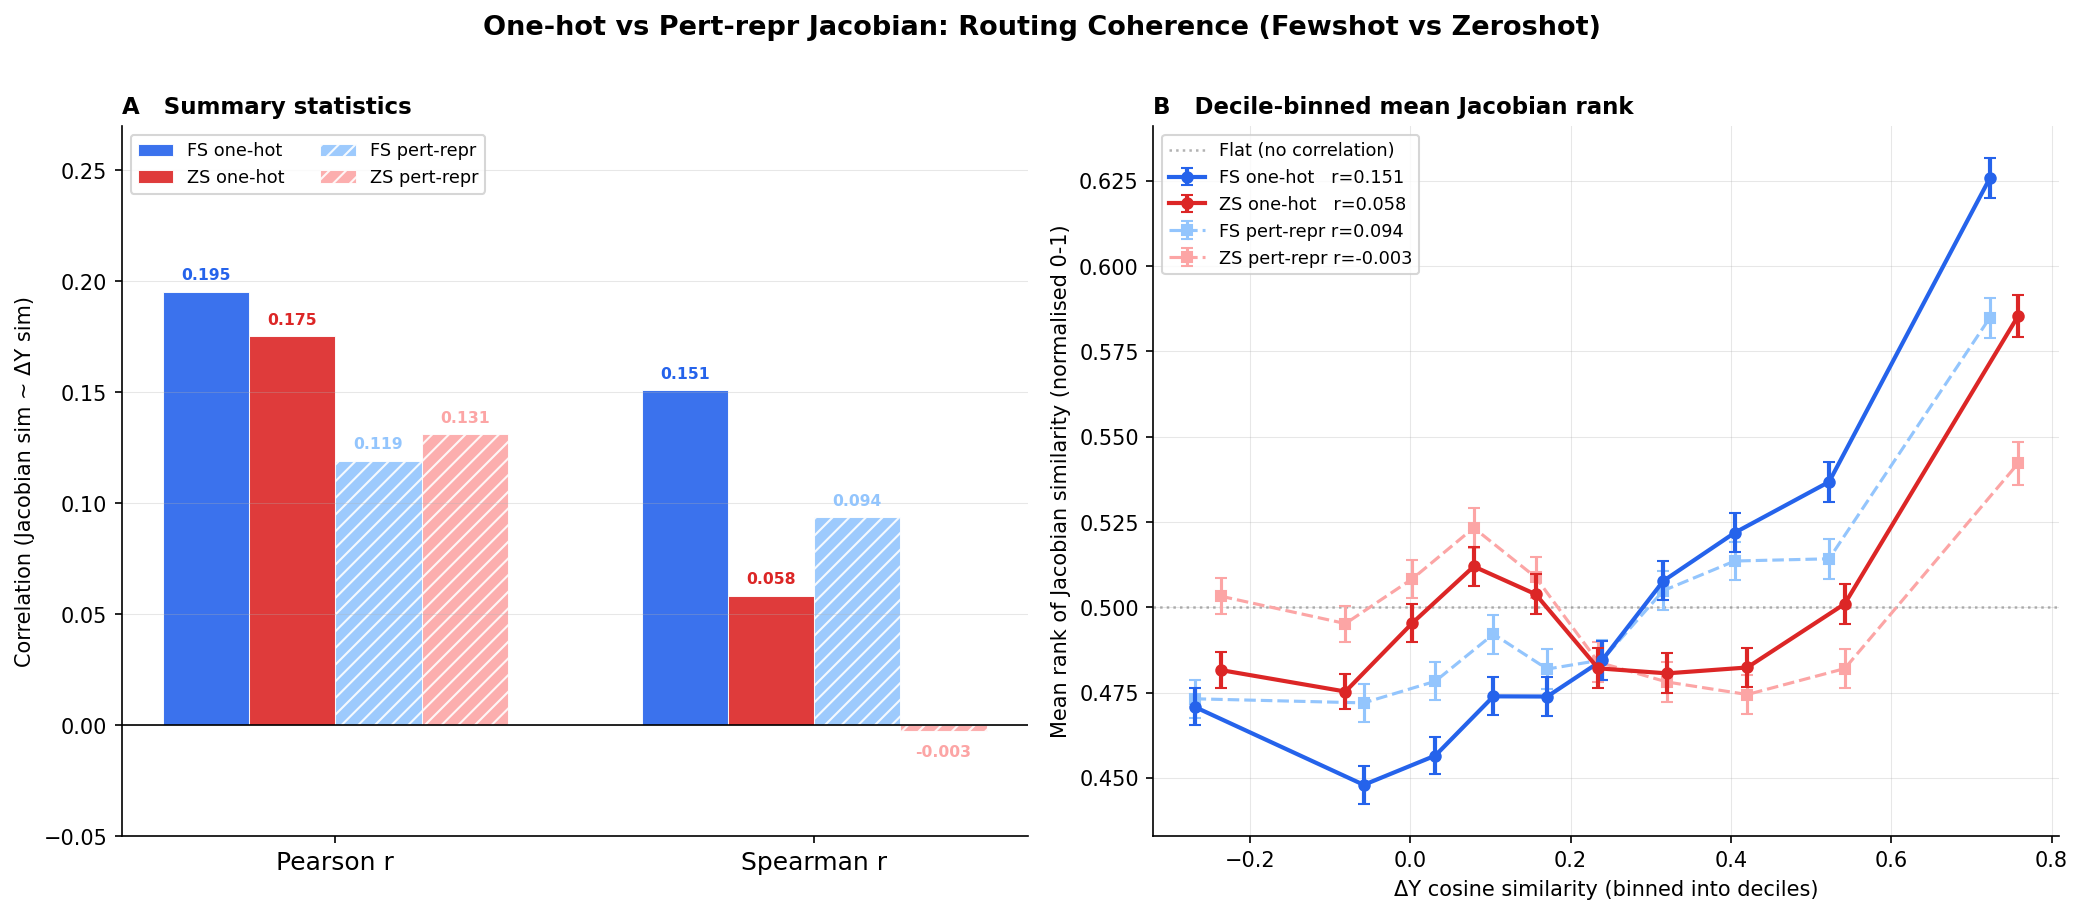

In [14]:

from IPython.display import Image, display
display(Image(filename='/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.png', width=1100))


In [15]:

import shutil
src = '/mnt/polished-lake/home/mbeheleramass/notebooks/2026-02-27-17-16_nb08_onehot_jacobian.ipynb'
dst = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb08_onehot_jacobian.ipynb'
shutil.copy2(src, dst)
print(f"Saved: {dst}")
